## Connection to a 'distributed' cluster 

In [1]:
from distributed import Executor, progress
from time import sleep

In [2]:
e = Executor('dscheduler:8786')
print(e)

<Executor: scheduler=dscheduler:8786 workers=2 threads=24>


In [3]:
def my_add_function(a, b):
    return a + b

f = e.submit(my_add_function, 1, 2)

In [4]:
f.done()

True

In [5]:
f.result()

3

In [6]:
f2 = e.submit(my_add_function, 2, f)
f2.result()

5

In [7]:
import random

sleep_times = [random.random() / 10 for i in range(1000)]

futures = e.map(sleep, sleep_times, pure=False)
progress(futures)

## Parameter search for machine learning

In [12]:
from sklearn.datasets import load_digits

digits = load_digits()

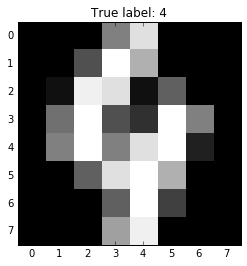

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

sample_idx = 124
plt.imshow(digits.data[sample_idx].reshape(8, 8), interpolation='nearest',
           cmap=plt.cm.gray)
plt.title("True label: %d" % digits.target[sample_idx]);

In [14]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np
from pprint import pprint

model = SVC(kernel='rbf')

param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

## Running one iteration on a single machine 

In [15]:
%%time
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=1)
search.fit(digits.data, digits.target)

print("Best parameter score: %0.3f" % search.best_score_)
pprint(search.best_params_)

Best parameter score: 0.939
{'C': 0.10000000000000001, 'class_weight': None, 'gamma': 0.001, 'tol': 0.0001}
CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.64 s


## Running the parameter search on the cluster

In [11]:
# Force the use of the development branch of joblib in scikit-learn
# won't be necessary once scikit-learn will get in sync with joblib
# 0.10+
import joblib
from sklearn.externals import joblib as skl_joblib
print('Monkeypatching scikit-learn embedded joblib')
for k, v in vars(joblib).items():
   setattr(skl_joblib, k, v)

Monkeypatching scikit-learn embedded joblib


In [16]:
from distributed.joblib import DistributedBackend
from joblib.parallel import register_parallel_backend, parallel_backend

register_parallel_backend('distributed', DistributedBackend)

In [19]:
with parallel_backend('distributed', scheduler_host='dscheduler:8786'):
    search = RandomizedSearchCV(model, param_space, cv=3, n_iter=30, verbose=10)
    search.fit(digits.data, digits.target)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.4s finished


In [20]:
print("Best parameter score: %0.3f" % search.best_score_)
pprint(search.best_params_)

Best parameter score: 0.976
{'C': 10000.0, 'class_weight': 'balanced', 'gamma': 0.001, 'tol': 0.0001}
